Загружаем библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Загружаем исходный датасет

In [2]:
df = pd.read_csv("dataset.csv")
df.sample(10)

,Unnamed: 0,statement,status
47522,47522,How do you find a psychiatrist I have asked th...,Depression
25553,25553,I have struggled with depression and anxiety s...,Depression
2491,2491,good luck,Normal
23209,23209,title says it all. i have to start taking my m...,Depression
22187,22187,Yesterday I told my friend how I felt. I have ...,Suicidal
17449,17449,I have fought and battled with depression majo...,Depression
34767,34767,Acid Reflux Attack Interested in other people'...,Anxiety
22801,22801,Hi. I do not know what I want from this post m...,Suicidal
660,660,The brain is now full of stressful thoughts. I...,Anxiety
5768,5768,"To be loved means ""Eternal life in someone's h...",Normal


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  53043 non-null  int64 
 1   statement   52681 non-null  object
 2   status      53043 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


Видно, что есть пропущенные данные, их нужно удалить

In [3]:
df = df.dropna()
df.shape

(52681, 3)

Так же удаляем ненужную колонку "Unnamed: 0"

In [4]:
df = df.drop(columns=["Unnamed: 0"])
df.columns

Index(['statement', 'status'], dtype='object')

Смотрим, есть ли повторяющиеся значения в statement

In [6]:
df.describe()

,statement,status
count,52681,52681
unique,51073,7
top,what do you mean?,Normal
freq,22,16343


Они есть, стоит оставить только уникалбные значения в statement

In [5]:
df = df.drop_duplicates(subset=["statement"])
df.describe()

,statement,status
count,51073,51073
unique,51073,7
top,oh my gosh,Normal
freq,1,16039


Чистим текст от ссылок, переносов строки и тд, а также переносим к нижнему регистру

In [6]:
import re

def pre_process(text):
    text = re.sub(r'http[s]?://\S+', '', text)
    # text = re.sub(r'\[.*?\]\(.*?\)', '', text)
    text = re.sub(r'@\w+', '', text)
    # text = re.sub(r'[^\w\s]', '', text)
    return text.strip().lower()

df['statement'] = df['statement'].apply(pre_process)
df.sample(10)

,statement,status
31728,a flag should be pretty.,Normal
25291,i do not understand how i have trouble with my...,Depression
45004,missed the gig,Normal
12224,"i just cannot deal with loneliness anymore,but...",Suicidal
8881,and then i get told that my lifes great and pe...,Suicidal
27276,another day closer to the end. one more down,Depression
22795,in 2017 i moved into a house with pain in the ...,Depression
45175,done feeding horse this snowy windy april morning,Normal
22069,i cannot grasp a coherent thought. i cannot th...,Suicidal
26088,i want to be loved. and not romantic love excl...,Suicidal


Делим выборку на трейн и тест

In [7]:
k = 0.2
classes = df["status"].unique()
test = pd.DataFrame(columns=df.columns)
for lable in classes:
    temp = df[df["status"] == lable]
    temp = temp.sample(int(temp.shape[0] * k))
    test = pd.concat([test, temp], ignore_index=True)
    df = df.drop(index=temp.index)
print("-------- train ----------")
print(test["status"].value_counts())
print("\n\n-------- test ----------")
print(df["status"].value_counts())

-------- train ----------
status
Normal                  3207
Depression              3017
Suicidal                2128
Anxiety                  723
Bipolar                  500
Stress                   458
Personality disorder     179
Name: count, dtype: int64


-------- test ----------
status
Normal                  12832
Depression              12070
Suicidal                 8513
Anxiety                  2894
Bipolar                  2001
Stress                   1835
Personality disorder      716
Name: count, dtype: int64


Теперь посмотрим на колличество семплов для каждого класса

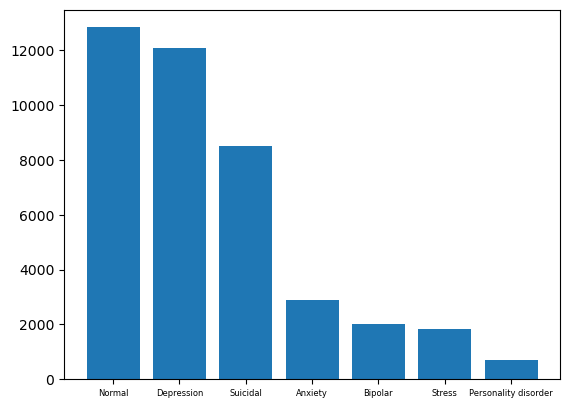

In [8]:
plt.bar(df["status"].value_counts().keys(), df["status"].value_counts().values)
plt.xticks(fontsize=6)
plt.show()

На лицо дисбаланс классов, сделаем ансемплинг частых классов и оверсемплинг редких, чтобы их количество стало равным 6000

Делаем ансемплинг

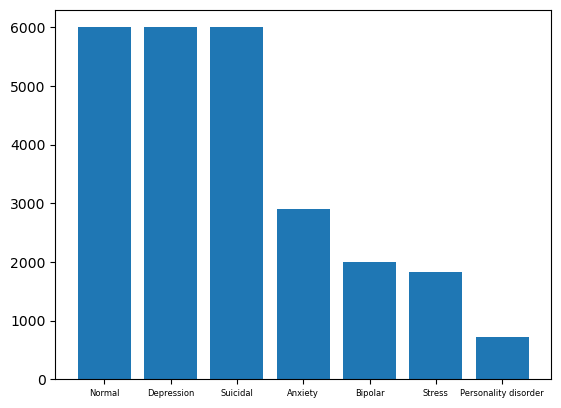

In [9]:
num = 6000
# ["Anxiety", "Bipolar", "Stress"]
for lable in ["Normal", "Depression", "Suicidal"]:
    unsampled = df[df["status"] == lable].sample(num)
    df = df.drop(index = df[df["status"] == lable].index)
    df = pd.concat([df, unsampled], ignore_index=True)

plt.bar(df["status"].value_counts().keys(), df["status"].value_counts().values)
plt.xticks(fontsize=6)
plt.show()


Делаем оверсемплинг

In [16]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=7)
X_train_resampled, y_train_resampled = ros.fit_resample(df.drop(columns=["status"]).values.reshape(-1, 1), df["status"])

In [13]:
y_train_resampled.value_counts()

status
Anxiety                 8000
Stress                  8000
Bipolar                 8000
Personality disorder    8000
Normal                  8000
Depression              8000
Suicidal                8000
Name: count, dtype: int64

Делаем эмбеденги

In [14]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')

d:\anaconda\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


В массиве X_train_resampled каждый элемент - это массив с одной строкой. Для модели нужен массив строк.

In [18]:
X_train_resampled = X_train_resampled.tolist()

for i in range(len(X_train_resampled)):
    X_train_resampled[i] = X_train_resampled[i][0]

In [16]:
embeddings = model.encode(X_train_resampled)

Сохраняем эмбединги тренеровочной выборки в json

In [15]:
import json

with open("train_embeddings_8000.json", "w") as f:
    json.dump(embeddings.tolist(), f)


TypeError: Object of type ndarray is not JSON serializable

Сохраняем таргеты тренеровочной выборки в json

In [21]:
with open("train_target_2.json", "w") as f:
    json.dump(y_train_resampled.tolist(), f)

Считаем эмбединги тестовой выборки

In [22]:
embeddings = model.encode(test["statement"])

Сохраняем эмбединги тестовой выборки в json

In [24]:
with open("test_embeddings_8000.json", "w") as f:
    json.dump(embeddings.tolist(), f)

Сохраняем таргеты тестовой выборки в json

In [26]:
with open("test_target_8000.json", "w") as f:
    json.dump(test_target.tolist(), f)